## In this notebook I'm going to train a neural network to learn which painting belongs to which artist.
The dataset that I used: https://www.kaggle.com/ikarus777/best-artworks-of-all-time

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.preprocessing as preprocess

We are using image_dataset_from_directory to load in the data from the disk. This is useful when we have a large dataset that we can't fit into the memory.<br>
It also takes care of resizing the images for us.

In [2]:
image_size = (256, 256)
batch_size = 64

X_train = preprocess.image_dataset_from_directory(
    "../input/best-artworks-of-all-time/images/images/",
    validation_split=0.2,
    subset="training",
    seed=25,
    image_size=image_size,
    batch_size=batch_size,
)
X_val = preprocess.image_dataset_from_directory(
    "../input/best-artworks-of-all-time/images/images/",
    validation_split=0.2,
    subset="validation",
    seed=25,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8774 files belonging to 51 classes.
Using 7020 files for training.
Found 8774 files belonging to 51 classes.
Using 1754 files for validation.


# Exploratory Data Analysis
Let's visualize some of the images.

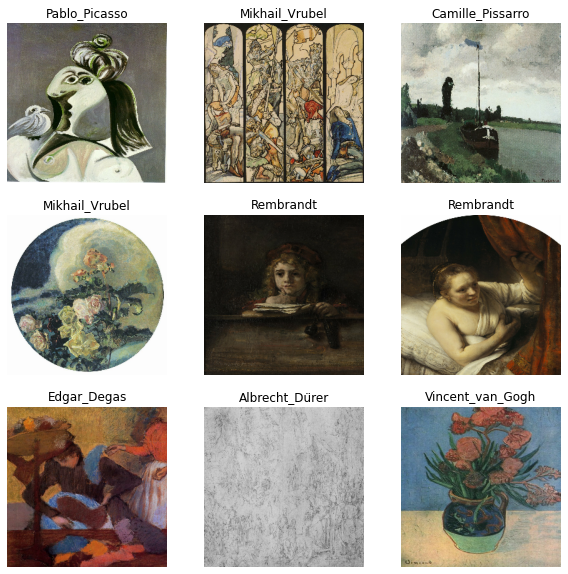

In [3]:
artists = X_train.class_names
plt.figure(figsize=(10, 10))
for images, labels in X_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(artists[labels[i]])
        plt.axis("off")

In [4]:
df = pd.read_csv("../input/best-artworks-of-all-time/artists.csv")
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [5]:
df = df.drop(["bio", "wikipedia"],axis=1)
df.head()

,id,name,years,genre,nationality,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,194


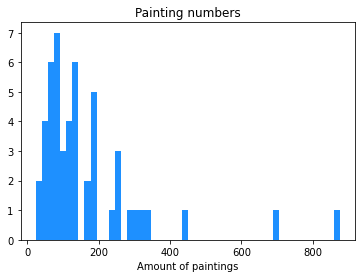

In [6]:
plt.hist(df["paintings"], 50, color='dodgerblue');
plt.title("Painting numbers");
plt.xlabel("Amount of paintings");

In [7]:
df.sort_values("paintings", ascending=False).head()

,id,name,years,genre,nationality,paintings
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,877
30,30,Edgar Degas,1834 - 1917,Impressionism,French,702
13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,439
15,15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,336
19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,328


We see that most artists have less than 400 paintings while there are two who have way more.

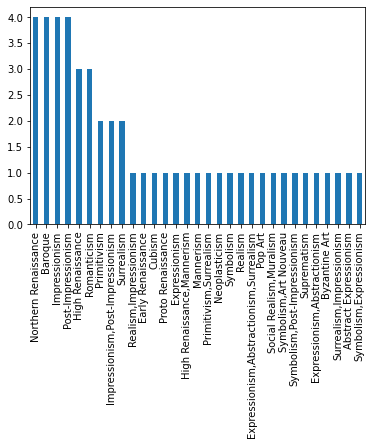

In [8]:
df.sort_values("paintings", ascending=False)["genre"].value_counts().plot.bar();

Here we can see that the data covers a wide variety of genres, where most genres are represented by only one artist.

In [9]:
summed_paintings = df[["genre", "paintings"]].groupby("genre").sum()
summed_paintings.sort_values("paintings", ascending=False)

,paintings
genre,
Impressionism,1370
Post-Impressionism,1048
Northern Renaissance,680
Baroque,586
Cubism,439
Romanticism,388
"Symbolism,Post-Impressionism",311
Primitivism,309
High Renaissance,301


We see that some genres barely have any painintgs while others have more than 500. <br>
Not surprisingly the top 4 is according to the 4 genres from where we have the most artists.

## Using image data augmentation
We can intriduce more examples by using augmentation (flip, rotation, etc.) this can reduce the chance of our model overfitting.<br>
We will only use horizontaly flipping, rotation and zooming as most paintings wouldn't make sense after a vertical flip.

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomZoom, Rescaling, RandomRotation
augmentations = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomZoom(0.3),
        RandomRotation(0.1),]
)

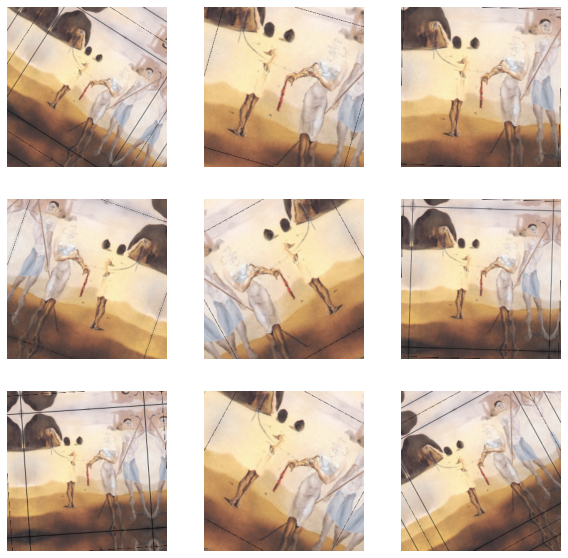

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in X_train.take(1):
    for i in range(9):
        new_image = augmentations(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(new_image[0].numpy().astype("uint8"))
        plt.axis("off")

We also need to normalize our data, so the values are between 0 and 1. <br>
For this we will create a normalization layer that we will use when we build the network.

In [12]:
normalize = Rescaling(1./255)

We use buffered prefetching so we can yield data from disk without having I/O becoming blocking

In [13]:
X_train = X_train.prefetch(buffer_size=32)
X_val = X_val.prefetch(buffer_size=32)

# Network
Let's build the network architecture

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
model = tf.keras.models.Sequential([
    augmentations,
    normalize,
    Conv2D(filters=16, kernel_size=(3,3), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005), activation='relu'), # width, height, channels
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=(3,3), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),   
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=len(labels), activation='softmax')
])

In [15]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(lr=0.0001), metrics=["accuracy"]) 

In [16]:
hist = model.fit(X_train, epochs=60, validation_data=X_val)

Epoch 1/60
110/110 [==============================] - 103s 940ms/step - loss: 4.1950 - accuracy: 0.1558 - val_loss: 4.3014 - val_accuracy: 0.0371
Epoch 2/60
110/110 [==============================] - 59s 539ms/step - loss: 4.1575 - accuracy: 0.1868 - val_loss: 4.2867 - val_accuracy: 0.0462
Epoch 3/60
110/110 [==============================] - 58s 530ms/step - loss: 4.1471 - accuracy: 0.1943 - val_loss: 4.2325 - val_accuracy: 0.1038
Epoch 4/60
110/110 [==============================] - 55s 503ms/step - loss: 4.1356 - accuracy: 0.2027 - val_loss: 4.1515 - val_accuracy: 0.1853
Epoch 5/60
110/110 [==============================] - 58s 527ms/step - loss: 4.1281 - accuracy: 0.2077 - val_loss: 4.1357 - val_accuracy: 0.1984
Epoch 6/60
110/110 [==============================] - 58s 530ms/step - loss: 4.1228 - accuracy: 0.2103 - val_loss: 4.1666 - val_accuracy: 0.1665
Epoch 7/60
110/110 [==============================] - 60s 546ms/step - loss: 4.1196 - accuracy: 0.2101 - val_loss: 4.1795 - val_a

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 32)     

Plotting the loss of the model

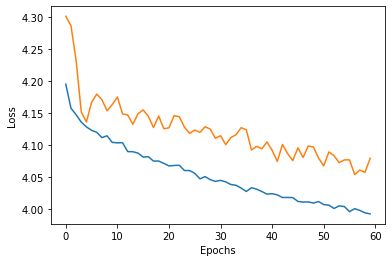

In [18]:
def plot_loss(h):
    plt.plot(h.history['loss'], label='Train')
    plt.plot(h.history['val_loss'], label='Validation')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
plot_loss(hist)

Predicting the correct artist is a complex task, our model's highest validation accuracy was just 20%. <br>
Plotting the loss we can see that it keeps decreasing, so with more training and with some more robust models for example ResNet, I beileve that we could achieve much better results. 